<a href="https://colab.research.google.com/github/mxa256/TGNB_Sentiment_Analysis/blob/main/TGNB_Sentiment_Analysis_051023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reddit Sentiment Analysis
###General steps:
####1.Scrape data
####2.Filter for word: "surgery"
####3.Clean text
####4.Sentiment analysis models


In [ ]:
#Install packages
!pip install -U spacy --quiet

In [ ]:
#Hugging face zero shot model 
!pip install transformers --quiet

In [ ]:
#Install packages
!pip install flair --quiet

In [ ]:
#Install packages
!pip install praw --quiet

In [ ]:
#Install packages
!python -m spacy download en_core_web_sm --quiet

2023-05-07 00:36:24.495866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 00:36:25.898694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-07 00:36:27.449617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-07 00:36:27.450288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" --quiet

In [ ]:
%%capture
#Scraping  
import praw
from praw.models import MoreComments

#General 
import pandas as pd
import numpy as np
import pprint
pd.options.mode.chained_assignment = None
import datetime as dt
from pprint import pprint
from itertools import chain
from google.colab import files
import re
import math

#NLP 
import nltk
import spacylemm
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
import en_core_web_sm
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer  
#from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nlp = en_core_web_sm.load()
tokenizer = ToktokTokenizer()
stopword_list = stopwords.words('english')
#stopword_list.remove('no')
#stopword_list.remove('not')
nlp = spacy.load("en_core_web_sm")
from textblob import TextBlob
import gensim
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
from wordcloud import WordCloud
# Hugging Face model
from transformers import pipeline

#Sklearn librairies
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#Plots
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

In [ ]:
#Install R
!pip install rpy2==3.5.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#Working with R
%load_ext rpy2.ipython

In [ ]:
%%capture 
%%R
#Install R packages 
install.packages("circlize")
install.packages("ggsci")
install.packages("Hmisc")
install.packages("reshape2")
install.packages("ggpubr")
install.packages("lmtest")

&> /dev/null

In [ ]:
%%R
#R packages
library(tidyverse)
library(circlize)
library(ggsci)
library(Hmisc)
library(reshape2)
#install.packages("devtools")
#devtools::install_github("kassambara/ggpubr')
#library(ggpubr)
library(lubridate)
library(lmtest)

In [ ]:
#Create reddit instance and provide client_id, client_secret and user_agent
#You will need a reddit account in order to access the API

reddit = praw.Reddit(client_id="",#my client id
                     client_secret="",  #your client secret
                     user_agent="Mona Ascha", #user agent name
                     username = "",     # your reddit username
                     password = "",  # your reddit password
                     check_for_async=False)  #Don't check for asynchronous environment  

In [ ]:
#These are the subs to scrape data from
#I tried to write a for loop to loop over the sub list but I could not get that to work
#We have to scrape each sub individually 

#sub = ['transgender', 'asktransgender', 'MTF', 'FTM', 'trans']  
subreddit1 = reddit.subreddit('transgender')   # Choosing the subreddit
subreddit2 = reddit.subreddit('asktransgender')   # Choosing the subreddit
subreddit3 = reddit.subreddit('MTF')   # Choosing the subreddit
subreddit4 = reddit.subreddit('FTM')   # Choosing the subreddit
subreddit5 = reddit.subreddit('trans')   # Choosing the subreddit

updates = []
for submission in subreddit1.search('surgery', limit=None):
  updates.append([submission.title, submission.created_utc, submission.id, submission.author])
for submission in subreddit2.search('surgery', limit=None):
  updates.append([submission.title, submission.created_utc, submission.id, submission.author])
for submission in subreddit3.search('surgery', limit=None):
  updates.append([submission.title, submission.created_utc, submission.id, submission.author])
for submission in subreddit4.search('surgery', limit=None):
  updates.append([submission.title, submission.created_utc, submission.id, submission.author])
for submission in subreddit5.search('surgery', limit=None):
  updates.append([submission.title, submission.created_utc, submission.id, submission.author])

updates_df = pd.DataFrame(updates, columns=['title', 'time_created', 'id', 'author'])
print(len(updates_df)) # 1217 posts

#id = author name
#updates_onlyid = updates_df[updates_df.author == id] #if we only want the posts by this author

1217


In [ ]:
# Let's peep the dataframe
updates_df.head()

,title,time_created,id,author
0,"'You're killing my kid': Over protests, House ...",1.683052e+09,135vznb,GenderPettifogging
1,"Nebraska: blockers, HRT removed from ban amid ...",1.679739e+09,121hfjz,starwarsgeek8
2,‘They just go to Thailand’: the long and costl...,1.682222e+09,12vuksa,Blah-Blah-Blah-2023
3,NEW study: Regret After Gender Affirming Surge...,1.677139e+09,119s49r,jackmolay
4,I’m a firm believer that trans surgeries are n...,1.677406e+09,11cbcij,Monka_Kowalska


In [ ]:
#Make it a csv
updates_df.to_csv('tgmetadata_may4.csv')
#DOWNLOADED CSV 

In [ ]:
#All analyses are made based on comments on the 1217 posts

comments = []
ids = updates_df['id']
for id in ids:
  # print(list(ids).index(id))
  submission = reddit.submission(id=id)
  submission.comments.replace_more(limit=None)
  for comment in submission.comments.list():
    comments.append([comment.author, comment.body, comment.submission.title, comment.replies, comment.score, comment.id, comment.parent_id])

comments_df = pd.DataFrame(comments, columns=['author', 'body', 'sub_title', 'replies', 'score', "ID", "parent_ID"])
     

In [ ]:
#Previewing the data frame
comments_df.to_csv("allcomments_may4.csv")
print(len(comments_df)) #26078 comments
comments_df.head()
#DOWNLOADED CSV 

26078


,author,body,sub_title,replies,score,ID,parent_ID
0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",(jilneiy),45,jilhn0b,t3_135vznb
1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",(jinxo5v),34,jiloul0,t3_135vznb
2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",(),24,jill8yr,t3_135vznb
3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",(),3,jiof1df,t3_135vznb
4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",(),2,jioparc,t3_135vznb


#Network Analyses - How do Redditors Interact

In [ ]:
%%R
#We will do this in R to work with dplyr and tidy
#We will re-upload the dataframe
comments_df <- read_csv("allcomments_may4.csv")
nrow(comments_df) #26078 comments

New names:
* `` -> `...1`
Rows: 26078 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (6): author, body, sub_title, replies, ID, parent_ID
dbl (2): ...1, score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] 26078


In [ ]:
%%R
#Creating an adjacency matrix

##Function for getting authors of each post 
getauthor <- function(ids){
    authors <- c()
    for (id in ids) {
        author <- comments_df %>%
          filter(ID == id) %>%
          select(author) %>%
          pull()
        authors <- c(authors, author)
    }
    return(authors)
}

In [ ]:
%%R
#Creating adjacency matrix 
adjacency <- comments_df %>%
  select(author, parent_ID) %>% #Selecting the author of the comment and the comment's parent
  separate(col = parent_ID, into = c("prefix", "parent_ID"), sep = "_") %>%
  filter(prefix != "t3") %>%
  mutate(parent = getauthor(parent_ID)) %>%
  group_by(author, parent) %>%
  dplyr::summarize(count = n()) %>%
  pivot_wider(names_from = parent, values_from = count) %>%
  filter(!is.na(author)) %>%
  column_to_rownames(var = "author") %>%
  as.matrix()

adjacency[is.na(adjacency)] <- 0 #Fill NA's with zero 



`summarise()` has grouped output by 'author'. You can override using the
`.groups` argument.


In [ ]:
%%R
replies <- comments_df %>%
  select(author, parent_ID) %>%
  separate(col = parent_ID, into = c("prefix", "parent_ID"), sep = "_") %>%
  filter(prefix != "t3") %>%
  nrow()
print(replies) #13263 replies to comments  
#There are a lot of interactions, but we only want to investigate the top interactors.

[1] 13263


In [ ]:
%%R
#Hoow many authors?
print(nrow(adjacency)) # 4714

#How many parents?
print(ncol(adjacency)) # 4612

#Too many to plot

[1] 4714
[1] 4612


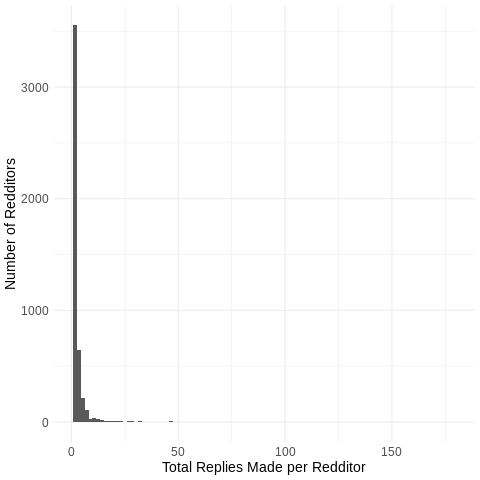

In [ ]:
%%R
#Distribution of number of interactions per author
rowsum <- adjacency %>%
  as.data.frame() %>%
  rowSums()

author_dist <- adjacency %>%
  as.data.frame() %>%
  mutate(inter_num = rowsum) %>%
  ggplot(aes(x = inter_num)) +
  geom_histogram(bins = 100) +
  theme_minimal() + 
  labs(x="Total Replies Made per Redditor", y="Number of Redditors") +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))

author_dist
#ggsave("totalrep.png", plot = author_dist, width = 5, height = 4)

#Most people only made less than a handful of comments. 
#Setting my threshold to be greater than 20 comments will collapse most people. 
#Redditors not meeting this threshold are "Others".

In [ ]:
%%R
#Getting authors
threshold_authors <- adjacency %>%
  as.data.frame() %>%
  rownames_to_column(var = "author") %>%
  mutate(inter_num = rowsum) %>%
  filter(rowsum >= 20) %>%  
  select(author) %>%
  pull()

In [ ]:
%%R
#Sorting everyone else into "Others"
others <- adjacency %>%
  as.data.frame() %>%
  rownames_to_column(var = "author") %>%
  filter(!(author %in% threshold_authors)) %>%
  column_to_rownames(var = "author") %>%
  colSums()

In [ ]:
%%R
#Final data frame
filtered_adjacency <- adjacency %>%
  as.data.frame() %>%
  rownames_to_column(var = "author") %>%
  filter(author %in% threshold_authors) %>%
  column_to_rownames(var = "author") %>%
  rbind(others)


In [ ]:
%%R 
print(dim(filtered_adjacency))
row.names(filtered_adjacency)[55] <- "Others" #Last row is the collapsed group
#DIM: [1]  55 4612

[1]   55 4612


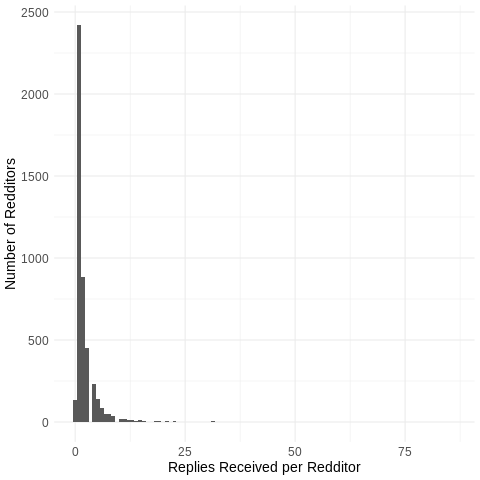

In [ ]:
%%R
#Distribution of number of interactions per parent
colsum <- filtered_adjacency %>%
  as.data.frame() %>%
  select(-`NA`) %>%
  colSums()
  
parent_dist <- data.frame("colsum" = colsum) %>%
  ggplot(aes(x = colsum)) +
  geom_histogram(bins = 100) +
  theme_minimal() +
  # coord_cartesian(ylim = c(0, 100)) + 
  labs(x="Replies Received per Redditor", y="Number of Redditors") +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
parent_dist
#ggsave("totalrec.png", plot = parent_dist, width = 5, height = 4)

#Most people received very few replies. We chose to set the threshold to 20. Everyone else is "Others".



In [ ]:
%%R
#Getting relevant redditors
threshold_parents <- filtered_adjacency %>%
  select_if(function(col) sum(col) >= 20) %>%
  colnames()

threshold_parents

 [1] "Jazzlike_Judgment877" "xjitz"                "NA"                  
 [4] "RedFumingNitricAcid"  "Harls_Isley"          "NatsumeAshikaga"     
 [7] "SirGentlemanOstrich"  "TransVictoriaGlory"   "Impossible_PhD"      
[10] "celestial_rayne"      "dr_steinblock"        "Longjumping-Menu5310"
[13] "Spirited-Painting964" "TooManyNamesStop"     "MonadoSoyBoi"        
[16] "RevengeOfSalmacis"    "HalcyonTwig"          "Moxie_Stardust"      
[19] "ElenTheMellon"        "Jolly-Room4626"       "Lokael"              
[22] "ZelfraxKT"            "Illgobananas2"        "Darkwolf860"         
[25] "Logbound"             "leaonas"              "LampshadeInTheRain"  
[28] "WildBassplayer"       "MadmanRogers"         "SSR_Adraeth"         
[31] "So-queer-I-am-hetero"


In [ ]:
%%R
#Sorting everyone else into Others
other_parents <- filtered_adjacency[, -which(names(filtered_adjacency) %in% threshold_parents)]
filtered_adjacency2 <- other_parents %>%
  mutate(Others = rowSums(other_parents)) %>%
  select(Others) %>%
  cbind(select_if(filtered_adjacency, function(col) sum(col) >= 20))

In [ ]:
%%R
head(filtered_adjacency2)

                 Others Jazzlike_Judgment877 xjitz NA RedFumingNitricAcid
AsryalDreemurr       46                    0     0  0                   0
AutoModerator         4                    0     0 43                   0
Barb_B_notReally     25                    0     2  0                   0
CaptainWildRose      30                    0     0  2                   0
Celllock             28                    0     0  0                   0
Chaoddian            25                    0     0  1                   0
                 Harls_Isley NatsumeAshikaga SirGentlemanOstrich
AsryalDreemurr             0               0                   0
AutoModerator              0               0                   0
Barb_B_notReally           0               0                   0
CaptainWildRose            0               0                   0
Celllock                   0               0                   0
Chaoddian                  0               0                   0
                 TransVicto

In [ ]:
%%R
#What proportion of interactions do these people account for?
#Replies made
rowsums <- filtered_adjacency2 %>%
  select(-`NA`) %>%
  rowSums()
all <- sum(rowsums)
rowprop <- rowsums / all
print(rowprop)

      AsryalDreemurr        AutoModerator     Barb_B_notReally 
        0.0042036005         0.0003655305         0.0024673307 
     CaptainWildRose             Celllock            Chaoddian 
        0.0027414786         0.0025587133         0.0022845655 
CuriousPrincessPeach          Darkwolf860        ElenTheMellon 
        0.0018276524         0.0042036005         0.0035639221 
  FetchMeMyLongsword          HalcyonTwig          Harls_Isley 
        0.0041122179         0.0020104176         0.0153522800 
      Impossible_PhD Individual_Angle2411      Jess_than_three 
        0.0026500960         0.0017362698         0.0008224436 
      Jolly-Room4626            Kampfer84            Kuunkulta 
        0.0045691310         0.0016448871         0.0018276524 
  LampshadeInTheRain             Logbound               Lokael 
        0.0031983917         0.0021931829         0.0023759481 
Longjumping-Menu5310         MadmanRogers            Milam1996 
        0.0021018002         0.002650096

In [ ]:
%%R
#Replies received
colsums <- filtered_adjacency2 %>%
  select(-`NA`) %>%
  colSums()
all <- sum(colsums)
colprop <- colsums / all
print(colprop)

              Others Jazzlike_Judgment877                xjitz 
         0.917481495          0.001827652          0.001919035 
 RedFumingNitricAcid          Harls_Isley      NatsumeAshikaga 
         0.003381157          0.007858905          0.001919035 
 SirGentlemanOstrich   TransVictoriaGlory       Impossible_PhD 
         0.003289774          0.002832861          0.002832861 
     celestial_rayne        dr_steinblock Longjumping-Menu5310 
         0.001919035          0.002650096          0.002101800 
Spirited-Painting964     TooManyNamesStop         MonadoSoyBoi 
         0.002010418          0.002101800          0.001919035 
   RevengeOfSalmacis          HalcyonTwig       Moxie_Stardust 
         0.004112218          0.001919035          0.002101800 
       ElenTheMellon       Jolly-Room4626               Lokael 
         0.004660514          0.002832861          0.002284565 
           ZelfraxKT        Illgobananas2          Darkwolf860 
         0.002101800          0.00219318

In [ ]:
%%R
adj_mat <- filtered_adjacency2 %>%
  select(-`NA`) %>%
  as.matrix()

In [ ]:
%%R
#This is a network graph allowing us to see user interactions -- the MAJORITY of the plot is people from the "Other" category
#That's what we expect. People log on, make a comment, and then log off 

# saving my plot
pdf("interactionmap.pdf", width = 960, height = 960)

chordDiagram(adj_mat, annotationTrack = "grid", preAllocateTracks = list(track.height = max(strwidth(unlist(dimnames(adj_mat))))))
#circos.track(track.index = 1, panel.fun = function(x, y){circos.text(CELL_META$xcenter, CELL_META$ylim[1], CELL_META$sector.index, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5)))}, bg.border = NA)

#dev.off()
#I cannot get the circos.track argument to work for the life of me 

#NLP

In [ ]:
#Read in comments
comments = pd.read_csv("allcomments_may4.csv")


###We have to preprocess the text first. 

Pre-processing text is an essential step in NLP tasks. Here are the common pre-process steps:

**Tokenization**: The first step is to split the text into individual words or tokens. There are different tokenization techniques such as white space tokenization, word-based tokenization, and character-based tokenization.

**Lowercasing**: In many cases, it is useful to lowercase all the words in the text. This is because uppercase and lowercase versions of the same word can be treated differently by the NLP algorithms. However, you may want to be careful with proper nouns and acronyms that should remain capitalized.

**Stop word removal:** Stop words are common words such as "the," "and," "a," "an," etc. that do not carry much meaning and can be removed to reduce the size of the text and speed up processing. Stop word removal is typically done after tokenization and lowercasing.

**Stemming and Lemmatization**: Stemming and lemmatization are techniques used to reduce words to their root form, which can help in reducing the dimensionality of the feature space. Stemming involves removing the suffixes from words to obtain the root form (e.g., "running" becomes "run"), whereas lemmatization involves using a dictionary to convert words to their base form (e.g., "ran" becomes "run").

**Normalization**: Normalization involves standardizing the text in various ways, such as converting numbers and dates to a standard format, removing punctuation, and replacing abbreviations with their full forms.

**Part-of-speech tagging**: POS tagging involves labeling each word in the text with its part of speech (e.g., noun, verb, adjective). This can help in disambiguating the meaning of words in the text.

**Named Entity Recognition (NER)**: Named Entity Recognition is a process of identifying the entities present in the text like names of people, organizations, locations, and other entities.

In [ ]:
#Pre-processing
# Removing capitals
def no_cap(text):
  lower = [x.lower() for x in text.split(' ')]
  text = ' '.join(lower)
  return text

# Removing characters 
def remove_special_characters(text):
    pattern = r"(@[A-Za-z0-9]+)|([^a-zA-z\s])|(\w+:\/\/\S+)|^rt|http.+?"
    text = re.sub(pattern, '', text)
    return text

# Lemmatizing
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# Removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Complete function
def prepare_text(text):
  text = no_cap(text)
  text = remove_special_characters(text)
  text = lemmatize_text(text)
  text = remove_stopwords(text)
  return text

In [ ]:
# Final complete text cleaning
normalized_comments = []
just_comments = comments['body']

for comment in just_comments:
  print(list(just_comments).index(comment))
  clean = prepare_text(comment)
  normalized_comments.append(clean)

In [ ]:
print(normalized_comments[0:5])


['kill trans child course exactly intent opponent bill include doctor parent sign speak committee meeting allow speak chairwoman rep erin par rwake say committee time question comment member public comment', 'hate way report ban puberty blocker hormone psychotherapy surgery ban', 'north carolinas lead medical expert demand lawmaker listen concern accept medical good practice rush dangerous antilgbtq agenda allison scott campaign southern equality say statement north carolinas medical expert demand never hear', 'never stop protect child never child eradicate tran people society', 'republican party completely fascist']


In [ ]:
#Adding new column to data frame
comments['normalized_body'] = normalized_comments

In [ ]:
#Some comments are repeats of each other. 
#They may be placeholders for deleted comments, spam, or technical glitches. 
#We want to remove all duplicates.

#Function for identifying repeats
def Repeat(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        print(i)
        k = i + 1
        for j in range(k, _size):
            if x[i] == x[j] and x[i] not in repeated:
                repeated.append(x[i])
    return repeated

#Getting a list of repeats
comm_list = list(comments['normalized_body'])
duplicated_comments = Repeat(comm_list)


In [ ]:
print(len(duplicated_comments)) #310 duplicates 

310


In [ ]:
#Removing duplicates
filtered_clean_comments = comments[~comments.normalized_body.isin(duplicated_comments)]

In [ ]:
print(len(filtered_clean_comments)) #23683
filtered_clean_comments.to_csv("normalized_nodup_comments_may4.csv")
#DOWNLOADED CSV

23683


In [ ]:
#filtered_clean_comments = pd.read_csv('normalized_nodup_comments_may4.csv')
filtered_clean_comments.head()


,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body
0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...
1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...
2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...
3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...
4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist


#Topic Extraction and Modeling

In [ ]:
#https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

#From Rachel. Check it out.

In [ ]:
#We want to understand what people are talking about in the comments.

#Converting to bag of words format (tokenization)
comments = filtered_clean_comments["normalized_body"]
print(comments[0:5])

corpus = []
for comment in comments:
  tokens = []
  for token in gensim.utils.simple_preprocess(comment):
    if len(token) > 3:
      tokens.append(token)
  corpus.append(tokens)
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

In [ ]:
print(len(corpus)) #23683
print(corpus[0:5])

23683
[['kill', 'trans', 'child', 'course', 'exactly', 'intent', 'opponent', 'bill', 'include', 'doctor', 'parent', 'sign', 'speak', 'committee', 'meeting', 'allow', 'speak', 'chairwoman', 'erin', 'rwake', 'committee', 'time', 'question', 'comment', 'member', 'public', 'comment'], ['hate', 'report', 'puberty', 'blocker', 'hormone', 'psychotherapy', 'surgery'], ['north', 'carolinas', 'lead', 'medical', 'expert', 'demand', 'lawmaker', 'listen', 'concern', 'accept', 'medical', 'good', 'practice', 'rush', 'dangerous', 'antilgbtq', 'agenda', 'allison', 'scott', 'campaign', 'southern', 'equality', 'statement', 'north', 'carolinas', 'medical', 'expert', 'demand', 'never', 'hear'], ['never', 'stop', 'protect', 'child', 'never', 'child', 'eradicate', 'tran', 'people', 'society'], ['republican', 'party', 'completely', 'fascist']]


In [ ]:
#One of the parameters of LDA models is how many topics to have. We want to test a range.

In [ ]:
#We will test 15 topics 
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    print(i)
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=10,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

#To ensure we have distinct topics, we minimize Jaccard similarity.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [ ]:
#But we still want coherent topics
#Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [ ]:
#We want high coherence and low stability scores 
print(coherences)
print(mean_stabilities)

[0.7182111531043296, 0.6915475830177538, 0.6770971226761402, 0.6553767804622042, 0.6533376018128003, 0.6571884339216348, 0.648302346094362, 0.650330133367422, 0.6423875697922887, 0.6472832307523888, 0.6393159506222944, 0.6296585882140857, 0.6227440533304145, 0.6014373284640809]
[0.5476190476190476, 0.4819317315026697, 0.4491829373383082, 0.41376592290914543, 0.383506119061039, 0.3532230746780869, 0.31508944144699536, 0.28969901276220544, 0.27751146393942644, 0.25826565102278215, 0.2531935280144846, 0.24531926243161523, 0.23530259564349887, 0.22226986334550589]


In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

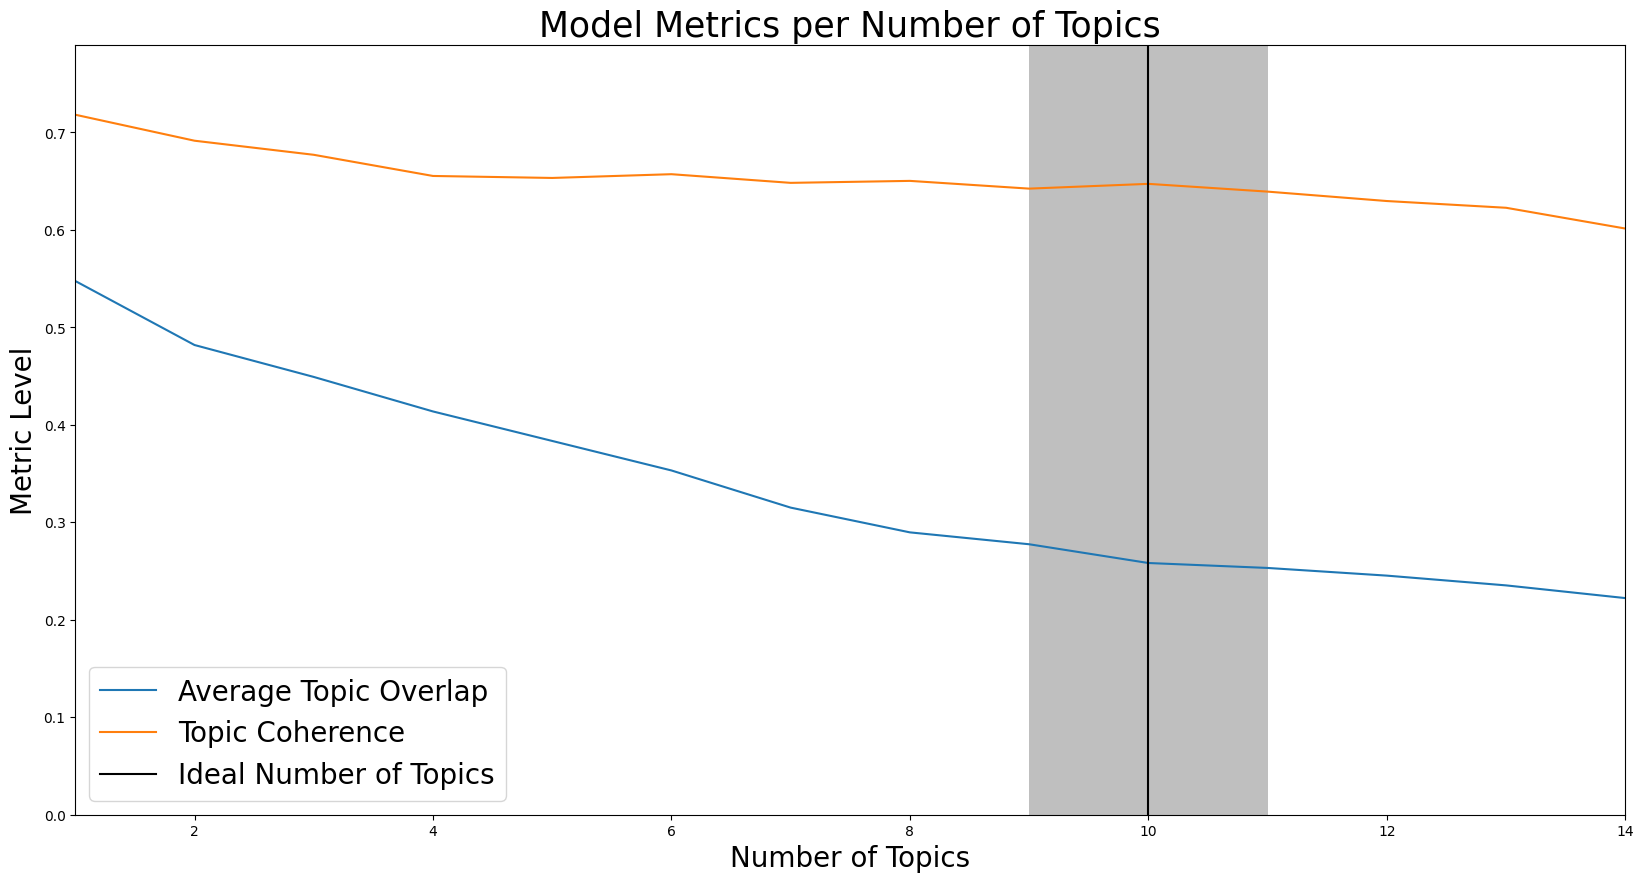

In [ ]:
#Want the ideal number of topics
#Ideal number is the greatest difference between stability and coherence 
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [ ]:
# getting a data frame for similarity and coherence
cohsim = {'Topic': num_topics[:-1],
          'Coherence': coherences,
          'Similarity': mean_stabilities}
cohsim = pd.DataFrame(cohsim, columns = ['Topic','Coherence', 'Similarity'])
cohsim.to_csv("topicscohsim_may4.csv")

In [ ]:
cohsim.head()

,Topic,Coherence,Similarity
0,1,0.718211,0.547619
1,2,0.691548,0.481932
2,3,0.677097,0.449183
3,4,0.655377,0.413766
4,5,0.653338,0.383506


In [ ]:
%%R
cohsim <- read_csv("topicscohsim_may4.csv")
colnames(cohsim) <- c("X1", "Number of Topics", "Topic Coherence", "Average Topic Overlap")

cohsim <- cohsim %>%
  select(-X1) %>%
  pivot_longer(cols = -`Number of Topics`, names_to = "Metric", values_to = "Score")

cohsim_plot <- cohsim %>%
  ggplot(aes(x = `Number of Topics`, y = Score, colour = Metric)) +
  geom_line() +
  xlim(1, 14) +
  ylim(0, 1) +
  theme_minimal() +
  theme(legend.position = c(0.3, 0.2)) +
  scale_colour_nejm() +
  geom_vline(aes(xintercept = 10)) + #Optimal number of topics is 10
  theme(axis.text = element_text(size = 12),
        #axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
cohsim_plot
ggsave("OptimalTopicR.png", plot = cohsim_plot, width = 5, height = 4)

New names:
* `` -> `...1`
Rows: 14 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (4): ...1, Topic, Coherence, Similarity

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
#Acquiring the top keywords for each topic and topic probabilities for each comment.
# Since 10 is the optimal number of topics
lda_10 = LDA_models[10]


In [ ]:
for i,topic in lda_10.show_topics(formatted=True, num_topics=10, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.024*"surgery" + 0.019*"insurance" + 0.013*"would" + 0.011*"cover" + 0.009*"surgeon" + 0.009*"need" + 0.007*"like" + 0.007*"letter" + 0.007*"year" + 0.006*"doctor"

1: 0.017*"like" + 0.015*"look" + 0.014*"surgery" + 0.014*"take" + 0.013*"year" + 0.011*"even" + 0.008*"post" + 0.008*"voice" + 0.008*"time" + 0.006*"still"

2: 0.021*"people" + 0.020*"think" + 0.017*"scar" + 0.012*"really" + 0.010*"make" + 0.009*"would" + 0.007*"tell" + 0.007*"look" + 0.006*"also" + 0.006*"even"

3: 0.019*"surgery" + 0.013*"want" + 0.012*"like" + 0.011*"people" + 0.010*"make" + 0.010*"time" + 0.010*"thing" + 0.010*"would" + 0.008*"need" + 0.008*"tell"

4: 0.023*"gender" + 0.020*"tran" + 0.019*"people" + 0.016*"woman" + 0.013*"change" + 0.013*"like" + 0.011*"surgery" + 0.009*"think" + 0.008*"well" + 0.008*"would"

5: 0.017*"like" + 0.016*"feel" + 0.016*"surgery" + 0.012*"would" + 0.010*"time" + 0.009*"work" + 0.009*"pain" + 0.009*"well" + 0.009*"week" + 0.008*"thing"

6: 0.024*"people" + 0.014*"know" + 0

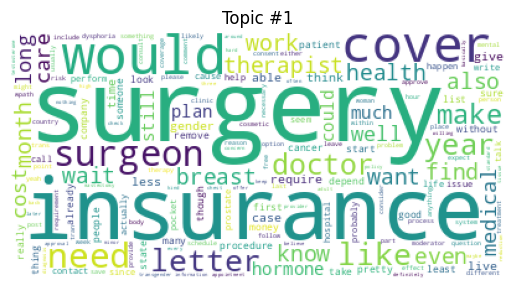

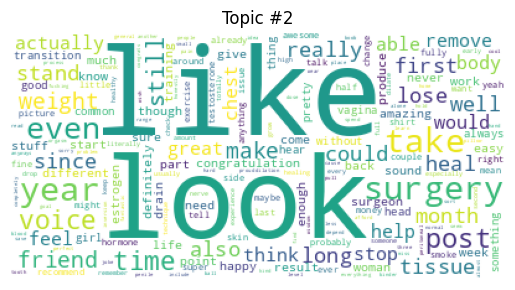

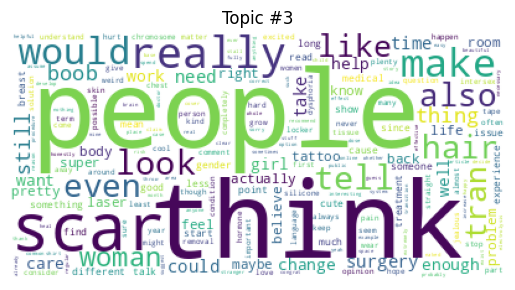

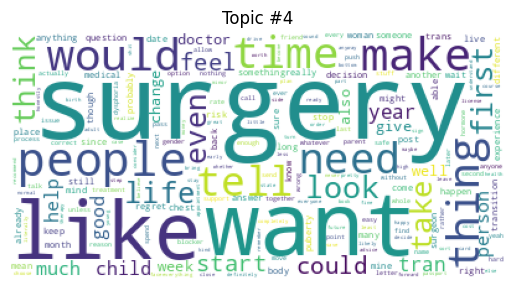

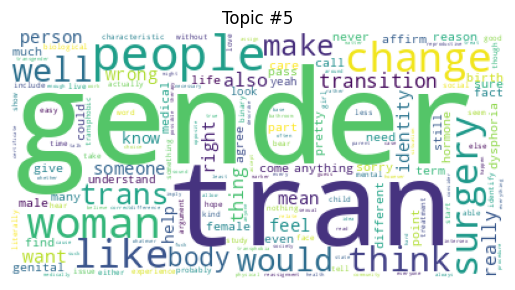

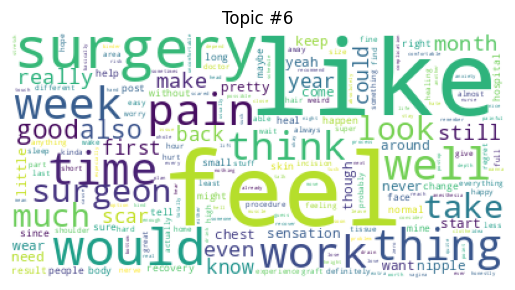

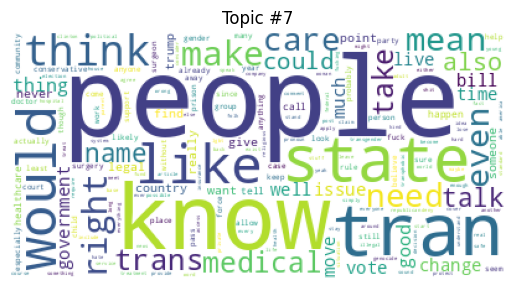

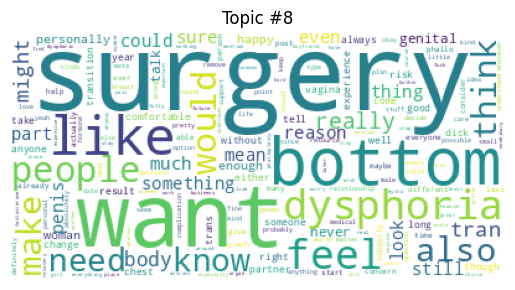

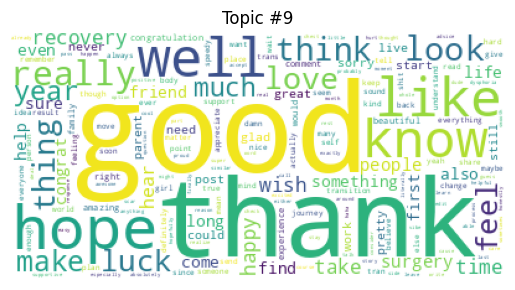

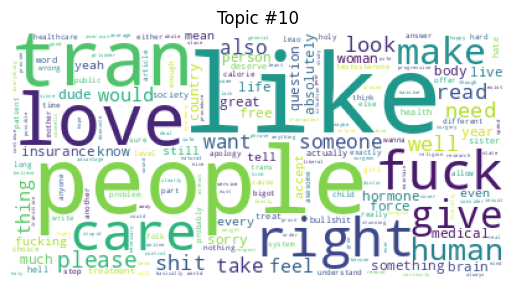

In [ ]:
#Word Cloud
for t in range(lda_10.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_10.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t + 1))
    plt.show()
     

In [ ]:
#Getting a dataframe with topic scores for each comment.
corpus_lda = lda_10[bow_corpus]
all_topics = lda_10.get_document_topics(corpus_lda, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(corpus_lda)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
    

In [ ]:
all_topics_df.to_csv("topic_scores_may4.csv") 

In [ ]:
%%R
comments <- read_csv("normalized_nodup_comments_may4.csv") %>%
  select(-`...1`, -`Unnamed: 0`)
print(head(comments))
topics <- read_csv("topic_scores_may4.csv") %>%
  select(-`...1`)
print(head(topics))
comments_topics <- cbind(comments, topics) %>%
  write_csv("comments_topics_may4.csv")

New names:
* `` -> `...1`
Rows: 23683 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (7): author, body, sub_title, replies, ID, parent_ID, normalized_body
dbl (3): ...1, Unnamed: 0, score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 x 8
  author           body  sub_title replies score ID    parent_ID normalized_body
  <chr>            <chr> <chr>     <chr>   <dbl> <chr> <chr>     <chr>          
1 gnurdette        "Kil~ 'You're ~ <praw.~    45 jilh~ t3_135vz~ kill trans chi~
2 rilehh_          "I h~ 'You're ~ <praw.~    34 jilo~ t3_135vz~ hate way repor~
3 OverallEcho9694  "\u2~ 'You're ~ <praw.~    24 jill~ t3_135vz~ north carolina~
4 ucannottell      "The~ 'You're ~ <praw.~     3 jiof~ t3_135vz~ never stop pro~
5 drunkclam        "the~ 'You're ~ <praw.~     2 jiop~ t3_135vz~ republican par~
6 Plast

#Sentiment Analysis
##There are many ways to perform Sentiment Analysis. We will experiment with different methods.
###1. Sentiment analysis with Random Forest model using emotion Twitter dataset.
###2. Sentiment analysis with Textblob.
###3. Sentiment analysis with VADER.
###4. Sentiment analysis with FLAIR model.
###5. Sentiment analysis with HuggingFace.

In [ ]:
#Hydrating Tweets using the Twitter API
#To get emotional scores, we used a pre-existing labelled Twitter dataset.
#import tweepy
#Twitter API
#auth = tweepy.OAuthHandler("uYwv2bUjNmoSw9kpuAVjege6b", "MndeDsR6oxLxt7uCLZWfa4VNe3TS3jRI43KkjvwUQoklvVpjJV")
#api = tweepy.API(auth)

In [ ]:
#Load in tweets
#http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html

anger = pd.read_csv ('anger.txt', sep='\t', header=None)
anger.to_csv ('anger.csv', index=None)

In [ ]:
anger.loc[1,1]

"So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted "

In [ ]:
fear = pd.read_csv ('fear.txt', sep='\t', header=None)
fear.to_csv ('fear.csv', index=None)

joy = pd.read_csv ('joy.txt', sep='\t', header=None)
joy.to_csv ('joy.csv', index=None)f

sadness = pd.read_csv ('sadness.txt', sep='\t', header=None)
sadness.to_csv ('sadness.csv', index=None)

In [ ]:
tweets = pd.concat([anger, fear, joy, sadness])
tweets.to_csv('tweets.csv')

In [ ]:
tweets.head()

,0,1,2,3
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [ ]:
tweets.columns = ['Obs', 'Tweet', 'Emotion', 'Intensity']
tweets.head()

,Obs,Tweet,Emotion,Intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [ ]:
print(len(tweets))

3613


In [ ]:
#Clean the tweets
clean_tweets = []

for tweet in list(tweets['Tweet']):
  print(list(tweets['Tweet']).index(tweet))
  cleaned = prepare_text(tweet)
  clean_tweets.append(cleaned)

tweets['clean'] = clean_tweets     

In [ ]:
tweets.head()

,Obs,Tweet,Emotion,Intensity,clean
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,fuk heck move fridge knock landlord door angry...
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,indian uber driver call someone n word move ve...
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,_ uk ask parcel deliver pick store address fum...
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,ef whichever butt wipe pull fire alarm davis b...
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,join put phone talk rude take money acc willyn...


In [ ]:
#We will be using a random forest regression model to predict emotional scores.
# Pipeline w/ Random Forest
from sklearn.ensemble import RandomForestRegressor
tfidf_vec = Pipeline([('tfidf_vec', TfidfVectorizer())])
tfidf = Pipeline([('tfidf', TfidfTransformer())])
preprocess = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('tfidf', tfidf)
])
pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestRegressor())
])


In [ ]:
#Applying it to Reddit comments for each emotion.
clean_df = tweets.drop('Tweet', axis = 1)
comments = pd.read_csv("comments_topics_may4.csv")

In [ ]:
clean_df[clean_df['Emotion'] == 'sadness']

,Obs,Emotion,Intensity,clean
0,40000,sadness,0.958,depression suck depression
1,40001,sadness,0.958,feel worthless always depression
2,40002,sadness,0.958,feel worthless always
3,40003,sadness,0.946,fibromyalgia really bad lately good mental sta...
4,40004,sadness,0.934,think lie bed day sulk life hit hard rn
...,...,...,...,...
781,40781,sadness,0.104,thank much home stunned happy think sink yet wow
782,40782,sadness,0.104,put winter duvet
783,40783,sadness,0.088,pretty love sky background purple highlight du...
784,40784,sadness,0.083,second artist announcement look good bluesf bl...


In [ ]:
# For sadness intensity
# Train test split
X = clean_df[clean_df['Emotion'] == 'sadness'].clean.values.astype('U')
y = clean_df[clean_df['Emotion'] == 'sadness'].Intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
redditX = comments.normalized_body.values.astype('U')
sadness_reddit = pipe.predict(redditX)
print(rmse1, sadness_reddit[1:5])

0.16013858374405993 [0.40875 0.44718 0.44998 0.38677]


In [ ]:
# For fear intensity
# Train test split
X = clean_df[clean_df['Emotion'] == 'fear'].clean.values.astype('U')
y = clean_df[clean_df['Emotion'] == 'fear'].Intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
redditX = comments.normalized_body.values.astype('U')
fear_reddit = pipe.predict(redditX)
print(rmse1, fear_reddit[1:5])

0.17077149584570545 [0.43169 0.45503 0.61583 0.403  ]


In [ ]:
# For joy intensity
# Train test split
X = clean_df[clean_df['Emotion'] == 'joy'].clean.values.astype('U')
y = clean_df[clean_df['Emotion'] == 'joy'].Intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
redditX = comments.normalized_body.values.astype('U')
joy_reddit = pipe.predict(redditX)
print(rmse1, joy_reddit[1:15])

0.17071389268855752 [0.31277 0.40776 0.27773 0.3521  0.35115 0.29969 0.38366 0.41605 0.30393
 0.36585 0.28727 0.29546 0.41789 0.62599]


In [ ]:
# For anger intensity
# Train test split
X = clean_df[clean_df['Emotion'] == 'anger'].clean.values.astype('U')
y = clean_df[clean_df['Emotion'] == 'anger'].Intensity

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
redditX = comments.normalized_body.values.astype('U')
anger_reddit = pipe.predict(redditX)
print(rmse1, anger_reddit[1:15])

0.1469645525549125 [0.44538 0.45551 0.58248 0.56806 0.46263 0.62057 0.4668  0.47089 0.57228
 0.51737 0.49366 0.60006 0.4583  0.50015]


In [ ]:
# Adding columns
comments["anger"] = anger_reddit
comments["fear"] = fear_reddit
comments["sad"] = sadness_reddit
comments["joy"] = joy_reddit
comments.to_csv("alldata_may4.csv")

#Some Visualizations

In [ ]:
%%R
#Checking the data
ogdata <- read_csv("alldata_may4.csv")
head(ogdata)

New names:
* `` -> `...1`
Rows: 23683 Columns: 23
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (7): author, body, sub_title, replies, ID, parent_ID, normalized_body
dbl (16): ...1, score, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, anger, fear, sad, joy

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 x 23
   ...1 author     body  sub_title replies score ID    parent_ID normalized_body
  <dbl> <chr>      <chr> <chr>     <chr>   <dbl> <chr> <chr>     <chr>          
1     0 gnurdette  "Kil~ 'You're ~ <praw.~    45 jilh~ t3_135vz~ kill trans chi~
2     1 rilehh_    "I h~ 'You're ~ <praw.~    34 jilo~ t3_135vz~ hate way repor~
3     2 OverallEc~ "\u2~ 'You're ~ <praw.~    24 jill~ t3_135vz~ north carolina~
4     3 ucannotte~ "The~ 'You're ~ <praw.~     3 jiof~ t3_135vz~ never stop pro~
5     4 drunkclam  "the~ 'You're ~ <praw.~  

In [ ]:
%%R
# making a correlation matrix
topics <- ogdata %>%
  select(`0`:`9`) %>%
  sapply(as.numeric)
colnames(topics) <- c("topic1", "topic2", "topic3", "topic4", "topic5", "topic6",
                      "topic7", "topic8", "topic9", "topic10")

c <- rcorr(topics, type = "spearman")$r %>%
  round(2)
p <- rcorr(topics, type = "spearman")$P %>%
  round(5)

In [ ]:
%%R
print(c)
print(p)

        topic1 topic2 topic3 topic4 topic5 topic6 topic7 topic8 topic9 topic10
topic1    1.00   0.34   0.38   0.32   0.25   0.17   0.32   0.15   0.24    0.41
topic2    0.34   1.00   0.54   0.45   0.36   0.33   0.37   0.27   0.38    0.57
topic3    0.38   0.54   1.00   0.47   0.42   0.34   0.43   0.29   0.43    0.61
topic4    0.32   0.45   0.47   1.00   0.34   0.27   0.36   0.23   0.34    0.50
topic5    0.25   0.36   0.42   0.34   1.00   0.15   0.33   0.19   0.27    0.45
topic6    0.17   0.33   0.34   0.27   0.15   1.00   0.15   0.13   0.21    0.34
topic7    0.32   0.37   0.43   0.36   0.33   0.15   1.00   0.14   0.29    0.47
topic8    0.15   0.27   0.29   0.23   0.19   0.13   0.14   1.00   0.17    0.31
topic9    0.24   0.38   0.43   0.34   0.27   0.21   0.29   0.17   1.00    0.45
topic10   0.41   0.57   0.61   0.50   0.45   0.34   0.47   0.31   0.45    1.00
        topic1 topic2 topic3 topic4 topic5 topic6 topic7 topic8 topic9 topic10
topic1      NA      0      0      0      0      0   

In [ ]:
%%R
#Get lower triangle
get_lower_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

lower_c <- get_lower_tri(c)
lower_p <- get_lower_tri(p)

melted_c <- melt(lower_c, na.rm = TRUE)
melted_p <- melt(lower_p, na.rm = TRUE)

colnames(melted_c) <- c("Variable1", "Variable2", "Correlation")
colnames(melted_p) <- c("Variable1", "Variable2", "P")
melted_cormat <- merge(melted_c, melted_p, by=c("Variable1", "Variable2"))

ggplot(data = melted_cormat, aes(Variable2, Variable1, fill = Correlation))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "#bc3c27", high = "#0072b5", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation Coefficient") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))+
 coord_fixed() +
  geom_text(aes(Variable2, Variable1, label = Correlation), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.8),
  legend.direction = "horizontal",
  legend.text = element_text(size = 12),
  legend.title = element_text(size = 16),
  axis.text = element_text(size = 12))+
  guides(fill = guide_colorbar(barwidth = 10, barheight = 1,
                title.position = "top", title.hjust = 0.5))
  ggsave("TopicsCorrelation.png", width = 5, height = 5)

In [ ]:
%%R
# If the topic score is greater than 0.2, then "1"
# function for converting into 1's and 0's 
convert10 <- function(vector){
  vector <- ifelse(vector >= 0.2, 1, 0)
  return(vector)
}

get_lower_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

yesno_redditors <- ogdata %>%
  dplyr::select(author, `0`:`9`, -c(anger, fear, sad, joy)) %>%
  `colnames<-`(c('author', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')) %>%
  group_by(author) %>%
  dplyr::summarize(across(everything(), mean)) %>%
  ungroup() %>%
  dplyr::select(-author) %>%
  sapply(convert10) %>%
  crossprod()
yesnoauthor_perc <- floor(t(yesno_redditors * 100 / length(unique(ogdata$author))))

# plotting the matrix
yesno_authors_plot <- yesnoauthor_perc %>%
  t() %>%
  get_lower_tri() %>%
  melt(na.rm = TRUE) %>%
  as.data.frame() %>%
  ggplot(aes(x = as.factor(Var1), y = as.factor(Var2), fill = `value`)) +
  geom_tile(color = "white") + 
  theme_minimal()+
  coord_fixed() +
  labs(x = "Topic Number", y = NULL, fill = "Percent Overlap") +
  scale_fill_gradient2(low = "white", high = "#0072b5") +
  theme(axis.text = element_text(size = 12),
        #axis.text.x = element_text(angle = 90),
        panel.grid.major = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14)) 
yesno_authors_plot
ggsave("TopicsOverlap.png", width = 5, height = 5)

In [ ]:
%%R
# checking correlations between sentiments
emotions <- ogdata %>%
  dplyr::select(anger, fear, sad, joy) %>%
  sapply(as.numeric)

colnames(emotions) <- c("Anger", "Fear", "Sadness", "Joy")

# Correlation matrix
c <- rcorr(emotions, type = "spearman")$r %>%
  round(2)
c
p <- rcorr(emotions,  type = "spearman")$P %>%
  round(2)
p

#Get lower triangle
get_lower_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }
lower_c <- get_lower_tri(c)

melted_c <- melt(lower_c, na.rm = TRUE)

colnames(melted_c) <- c("Variable1", "Variable2", "Correlation")

senticorr_plot <- melted_c %>%
  filter(Variable1 != Variable2) %>%
  ggplot(aes(Variable2, Variable1, fill = Correlation))+
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "#bc3c27", high = "#0072b5", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation Coefficient") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))+
 coord_fixed() +
  geom_text(aes(Variable2, Variable1, label = Correlation), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.8),
  legend.direction = "horizontal",
  legend.text = element_text(size = 12),
  legend.title = element_text(size = 16),
  axis.text = element_text(size = 12))+
  guides(fill = guide_colorbar(barwidth = 10, barheight = 1,
                title.position = "top", title.hjust = 0.5))
senticorr_plot
ggsave("senticorr_plot.png", width = 5, height = 5)

##Sentiment Analysis: Textblob

In [ ]:
posts = pd.read_csv("normalized_nodup_comments_may4.csv")

In [ ]:
posts = posts.iloc[: , 1:]
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist


In [ ]:
#Let's pre-process from scratch
#Pre-processing
#Remove special characters
#Lowercase
#Tokenize
#Remove stopwords
#Lemmatize
#Remove punctuation/numbers (not necessary)

#Create a function to remove special characters
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the '#' symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Cleaning the text: remove special characters
posts['clean_comments']= posts['body'].apply(cleanTxt)

#Show the clean text
posts.head()


,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,clean_comments
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,"Killing trans children is, of course, exactly ..."
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,I hate that the way they report a ban on puber...
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,“North Carolina’s leading medical experts are ...
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,They will never just stop with “protecting the...
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,the republican party is completely fascist


In [ ]:
#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

#Cleaning the text

#Cleaning the text: remove special characters
posts['clean_comments']= posts['clean_comments'].apply(remove_emoji)

#Show the clean text
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,clean_comments
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,"Killing trans children is, of course, exactly ..."
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,I hate that the way they report a ban on puber...
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,“North Carolina’s leading medical experts are ...
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,They will never just stop with “protecting the...
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,the republican party is completely fascist


In [ ]:
#Remove additional punctuation
#Cleaning the text: remove special characters
posts['clean_comments']= posts['clean_comments'].apply(remove_special_characters)

#Show the clean text
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,clean_comments
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,Killing trans children is of course exactly th...
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,I hate that the way they report a ban on puber...
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,North Carolinas leading medical experts are de...
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,They will never just stop with protecting the ...
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,the republican party is completely fascist


In [ ]:
#Cleaning the text: tokenize
posts['clean_comments'] = posts['clean_comments'].apply(word_tokenize)
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,clean_comments
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,"[Killing, trans, children, is, of, course, exa..."
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,"[I, hate, that, the, way, they, report, a, ban..."
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,"[North, Carolinas, leading, medical, experts, ..."
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,"[They, will, never, just, stop, with, protecti..."
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,"[the, republican, party, is, completely, fascist]"


In [ ]:
#Cleaning the text: lowercase
posts['clean_comments'] = posts['clean_comments'].apply(lambda x: [word.lower() for word in x])
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,clean_comments
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,"[killing, trans, children, is, of, course, exa..."
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,"[i, hate, that, the, way, they, report, a, ban..."
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,"[north, carolinas, leading, medical, experts, ..."
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,"[they, will, never, just, stop, with, protecti..."
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,"[the, republican, party, is, completely, fascist]"


In [ ]:
#Cleaning the text: remove stopwords

all_stopwords = nlp.Defaults.stop_words


#posts['clean_comments'] = posts['clean_comments'].apply(lambda x: [word.remove_stopwords() for word in x])
posts['clean_comments'] = posts['clean_comments'].apply(lambda x: [word for word in x if not word in stopword_list and len(word)>2 and not word in ["www", "http", "https", "reddit", "nan"]])
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,clean_comments
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,"[killing, trans, children, course, exactly, in..."
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,"[hate, way, report, ban, puberty, blockers, ho..."
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,"[north, carolinas, leading, medical, experts, ..."
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,"[never, stop, protecting, children, never, chi..."
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,"[republican, party, completely, fascist]"


In [ ]:
#Cleaning the text: lemmatize
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize a token
def lemmatize_token(token):
    return lemmatizer.lemmatize(token)

# define a function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    return [lemmatize_token(token) for token in tokens]

# load your pandas dataframe
# apply the lemmatize_tokens function to a column of tokens
posts['clean_comments'] = posts['clean_comments'].apply(lemmatize_tokens)

#posts['clean_comments'] = posts['clean_comments'].apply(lambda x: [lemmatize_text(token) for token in x])
posts.head(10)


In [ ]:
#Textblob does not require tokenized words for sentiment analysis
#Rule based sentiment analysis
#Textblob will ignore the words that it doesn’t know, it will consider words and phrases that it can assign polarity to and averages to get the final score.

#Create a function to get the subjectivity
def getSubjectivity(text):
 return TextBlob(text).sentiment.subjectivity

#Create a function to get Polarity
def getPolarity(text):
 return TextBlob(text).sentiment.polarity

#Now we create a new column for what we just did and add it to the Tweet_df dataframe
#posts['Subjectivity'] = posts['normalized_body'].apply(getSubjectivity)
#posts['Polarity'] = posts['normalized_body'].apply(getPolarity)

posts['Subjectivity'] = posts['body'].apply(getSubjectivity)
posts['Polarity'] = posts['body'].apply(getPolarity)

#Now display data
posts.head()

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,Subjectivity,Polarity
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,0.158333,0.125000
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,0.900000,-0.800000
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,0.200000,0.066667
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,0.000000,0.000000
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,0.400000,0.100000


In [ ]:
#Group the range of Polarity into different categories
#def getInsight(score):
#    if score < 0:
#        return "Negative"
#    elif score == 0:
#        return "Neutral"
#    else:
#        return "Positive"

def getInsight(score):
    if score < -0.1: #Think about what threshold you want to set 
        return "Negative"
    elif score > 0.1:
        return "Positive"
    else:
        return "Neutral"

posts['Insight'] = posts['Polarity'].apply(getInsight)

posts.head(5)

,Unnamed: 0.1,Unnamed: 0,author,body,sub_title,replies,score,ID,parent_ID,normalized_body,Subjectivity,Polarity,Insight
0,0,0,gnurdette,"Killing trans children is, of course, exactly ...","'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,45,jilhn0b,t3_135vznb,kill trans child course exactly intent opponen...,0.158333,0.125000,Positive
1,1,1,rilehh_,I hate that the way they report a ban on puber...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,34,jiloul0,t3_135vznb,hate way report ban puberty blocker hormone ps...,0.900000,-0.800000,Negative
2,2,2,OverallEcho9694,“North Carolina’s leading medical experts are ...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,24,jill8yr,t3_135vznb,north carolinas lead medical expert demand law...,0.200000,0.066667,Neutral
3,3,3,ucannottell,They will never just stop with “protecting the...,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,3,jiof1df,t3_135vznb,never stop protect child never child eradicate...,0.000000,0.000000,Neutral
4,4,4,drunkclam,the republican party is completely fascist,"'You're killing my kid': Over protests, House ...",<praw.models.comment_forest.CommentForest obje...,2,jioparc,t3_135vznb,republican party completely fascist,0.400000,0.100000,Neutral


In [ ]:
posts["Insight"].value_counts()

Positive    11520
Neutral      9509
Negative     2654
Name: Insight, dtype: int64

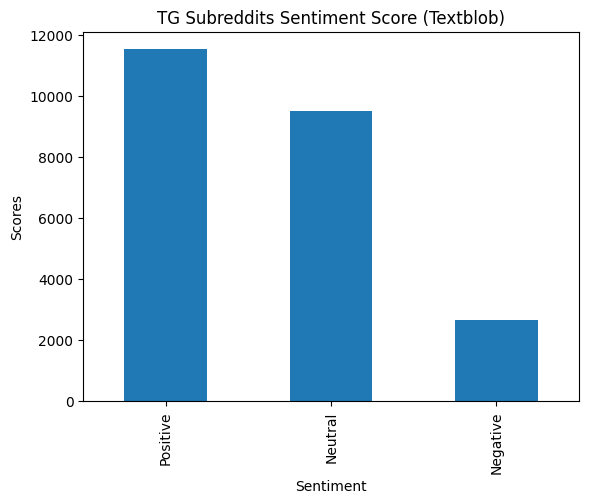

In [ ]:
#Plot the values count of sentiment
plt.title("TG Subreddits Sentiment Score (Textblob)")
plt.xlabel("Sentiment")
plt.ylabel("Scores")
plt.rcParams["figure.figsize"] = (10,8)
posts["Insight"].value_counts().plot(kind="bar", color="#2078B4")
plt.show()


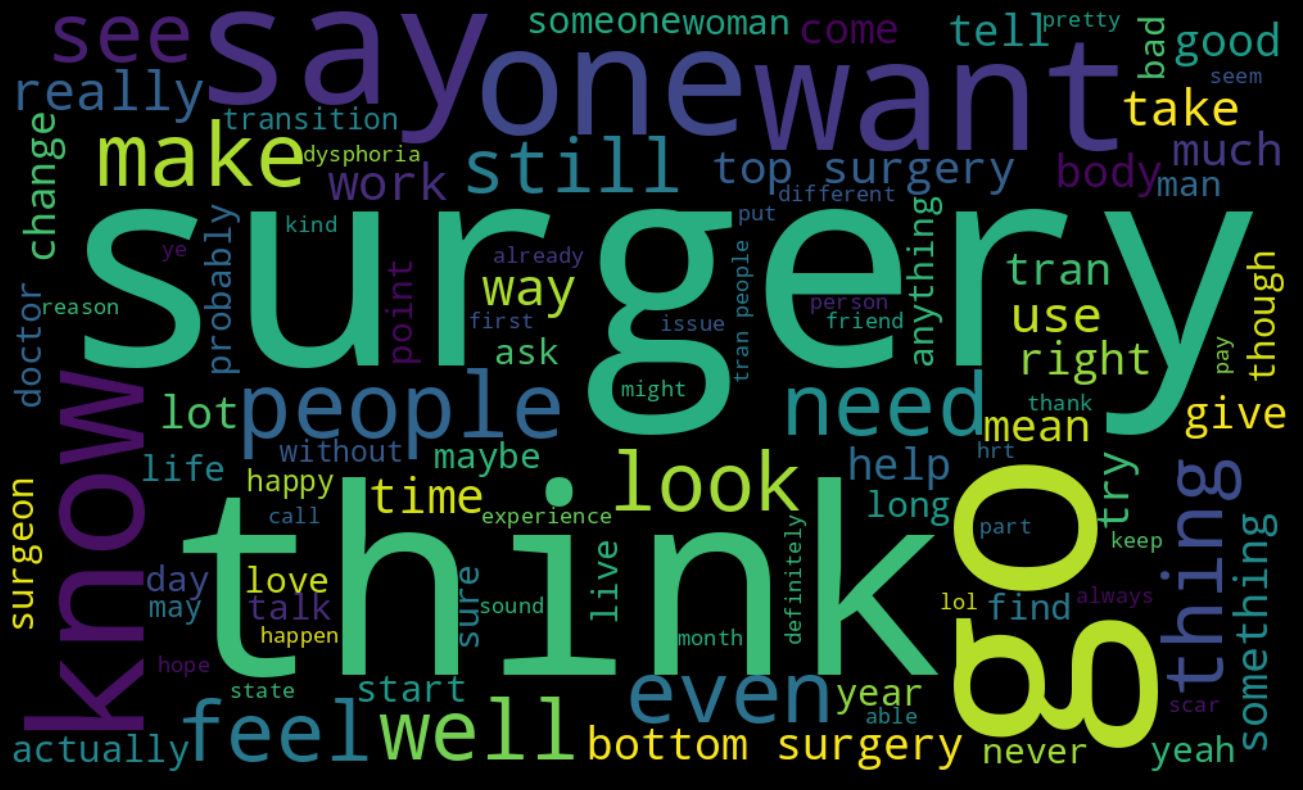

In [ ]:
text = ' '.join( [comments for comments in posts['normalized_body']] ) #To join all comments
    # generate word cloud 
wordcloud = WordCloud(width=1000, height = 600,                      
                      max_words = 100,
                      background_color="black").generate(text)

  # Display the generated image:
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [ ]:
#Let's use VADER
#This is another rule based sentiment analysis 
#We dont' need to pre process our sentences for VADER, so I am going to use the actual body of the post 
#https://towardsdatascience.com/are-you-scared-vader-understanding-how-nlp-pre-processing-impacts-vader-scoring-4f4edadbc91d

sia = SentimentIntensityAnalyzer()

results = []

for line in posts['body']:
    pol_score = sia.polarity_scores(line)
    pol_score['body'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'body': 'Killing trans children is, of course, exactly the intent.\n'
          '\n'
          '> Opponents of the bill, including doctors and parents, had signed up to speak during '
          "the committee meeting. But they weren't allowed to speak. Chairwoman Rep Erin Paré, "
          'R-Wake, said the committee had no time for questions or comments from members, or for '
          'public comment.',
  'compound': -0.6705,
  'neg': 0.097,
  'neu': 0.903,
  'pos': 0.0},
 {'body': 'I hate that the way they report a ban on puberty blockers, hormones, and psychotherapy '
          'as a "surgery ban"',
  'compound': -0.8979,
  'neg': 0.456,
  'neu': 0.544,
  'pos': 0.0},
 {'body': '“North Carolina’s leading medical experts are demanding that lawmakers listen to their '
          'concerns, and accepted medical best practices, before rushing through this dangerous '
          'anti-LGBTQ+ agenda,” Allison Scott, of the Campaign for Southern Equality, said in a '
          'statement.

In [ ]:
#Let's test it out with a couple of setnences. 

sentence = "I hate my boss, he's the worst and constantly abuses me."
test = sia.polarity_scores(sentence)
print(test)

sentence = "I love my boss, he's the best and constantly praises me."
test = sia.polarity_scores(sentence)
print(test)

sentence = "north carolinas lead medical expert demand lawmaker listen concern accept medical good practice rush dangerous antilgbtq agenda allison scott campaign southern equality say statement north carolinas medical expert demand never hear	"
test = sia.polarity_scores(sentence)
print(test)

{'neg': 0.62, 'neu': 0.38, 'pos': 0.0, 'compound': -0.9081}
{'neg': 0.0, 'neu': 0.372, 'pos': 0.628, 'compound': 0.9153}
{'neg': 0.162, 'neu': 0.691, 'pos': 0.146, 'compound': 0.1027}


In [ ]:
df = pd.DataFrame.from_records(results)
df.head()

,neg,neu,pos,compound,body
0,0.097,0.903,0.000,-0.6705,"Killing trans children is, of course, exactly ..."
1,0.456,0.544,0.000,-0.8979,I hate that the way they report a ban on puber...
2,0.103,0.780,0.117,0.1962,“North Carolina’s leading medical experts are ...
3,0.000,0.918,0.082,0.2235,They will never just stop with “protecting the...
4,0.368,0.378,0.255,-0.2944,the republican party is completely fascist


In [ ]:
#Let's use VADER
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,neg,neu,pos,compound,body,label
0,0.097,0.903,0.000,-0.6705,"Killing trans children is, of course, exactly ...",-1
1,0.456,0.544,0.000,-0.8979,I hate that the way they report a ban on puber...,-1
2,0.103,0.780,0.117,0.1962,“North Carolina’s leading medical experts are ...,0
3,0.000,0.918,0.082,0.2235,They will never just stop with “protecting the...,1
4,0.368,0.378,0.255,-0.2944,the republican party is completely fascist,-1


In [ ]:
#Making an actual sentiment label 
df['sentiment'] = 'Neutral'
df.loc[df['label'] == 1, 'sentiment'] = 'Positive'
df.loc[df['label'] == -1, 'sentiment'] = 'Negative'
df.head()

,neg,neu,pos,compound,body,label,sentiment
0,0.097,0.903,0.000,-0.6705,"Killing trans children is, of course, exactly ...",-1,Negative
1,0.456,0.544,0.000,-0.8979,I hate that the way they report a ban on puber...,-1,Negative
2,0.103,0.780,0.117,0.1962,“North Carolina’s leading medical experts are ...,0,Neutral
3,0.000,0.918,0.082,0.2235,They will never just stop with “protecting the...,1,Positive
4,0.368,0.378,0.255,-0.2944,the republican party is completely fascist,-1,Negative


In [ ]:
print(df.sentiment.value_counts())

Positive    12722
Neutral      5550
Negative     5411
Name: sentiment, dtype: int64


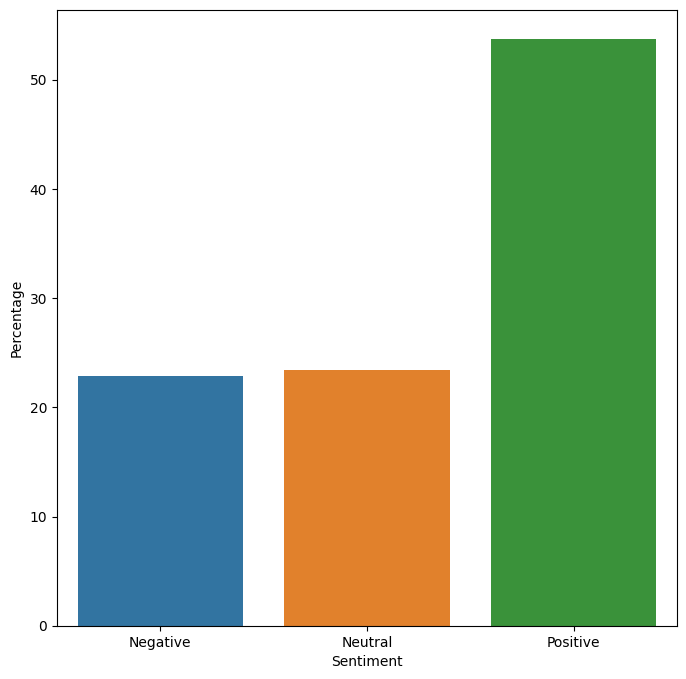

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_xlabel("Sentiment")

plt.show()

#https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

In [ ]:
#How well do the textblob and vader scores align? Something to explore.

#Sentiment Analysis: FLAIR

In [ ]:
#Pre trained sentiment analysis models 
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
#Instantiate the classifier 
classifier = TextClassifier.load('en-sentiment')

In [ ]:
#Testing it out
sentence = Sentence('The food was terrible!')
print(sentence)
classifier.predict(sentence)

#print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

Sentence[5]: "The food was terrible!"
Sentence above is:  ['Sentence[5]: "The food was terrible!"'/'NEGATIVE' (1.0)]


In [ ]:
posts['flair_sentences'] = posts['body'].apply(Sentence)
posts.head()

In [ ]:
#results_flair = []
#values_flair = []

#for sentence in posts['flair_sentences']:
#  classifier.predict(sentence)
#  score = sentence.labels[0].score
#  value = sentence.labels[0].value
#  results_flair.append(score)
#  values_flair.append(score)

#pprint(results_flair[:5], width=100)
#pprint(values_flair[:5], width=100)

#Another way to get the values
#https://medium.com/@AmyGrabNGoInfo/sentiment-analysis-hugging-face-zero-shot-model-vs-flair-pre-trained-model-57047452225d

def score_flair(text):
 # Flair tokenization
 sentence = Sentence(text)
 # Predict sentiment
 classifier.predict(sentence)
 # Extract the score
 score = sentence.labels[0].score
 # Extract the predicted label
 value = sentence.labels[0].value
 # Return the score and the predicted label
 return score, value

# Get sentiment score for each review
posts['scores_flair'] = posts['body'].apply(lambda s: score_flair(s)[0])

# Predict sentiment label for each review
posts['pred_flair'] = posts['body'].apply(lambda s: score_flair(s)[1])

# Check the distribution of the score
posts['scores_flair'].describe()

count    23683.000000
mean         0.940671
std          0.112499
min          0.500303
25%          0.948661
50%          0.994914
75%          0.999414
max          0.999999
Name: scores_flair, dtype: float64

In [ ]:
posts['pred_flair'].value_counts()

NEGATIVE    13963
POSITIVE     9720
Name: pred_flair, dtype: int64

#Sentiment Analysis: Hugging Face

In [ ]:
# Define pipeline
classifier = pipeline(task="zero-shot-classification", 
                      model="facebook/bart-large-mnli",
                      device=0) 

In [ ]:
# Put reviews in a list
sequences = posts['body'].to_list()

# Define the candidate labels 
candidate_labels = ["positive", "neutral", "negative"]

# Set the hypothesis template
hypothesis_template = "The sentiment of this review is {}."

# Prediction results
hf_prediction = classifier(sequences, candidate_labels, hypothesis_template=hypothesis_template)

# Save the output as a dataframe
hf_prediction = pd.DataFrame(hf_prediction)

# Take a look at the data
#The first label in the labels list is the predicted sentiment for each review
#The first score in the scores list is the corresponding score prediction
hf_prediction.head()

,sequence,labels,scores
0,"Killing trans children is, of course, exactly ...","[negative, neutral, positive]","[0.9751885533332825, 0.0139091145247221, 0.010..."
1,I hate that the way they report a ban on puber...,"[negative, neutral, positive]","[0.9837645888328552, 0.009502574801445007, 0.0..."
2,“North Carolina’s leading medical experts are ...,"[negative, neutral, positive]","[0.9737279415130615, 0.015468863770365715, 0.0..."
3,They will never just stop with “protecting the...,"[negative, positive, neutral]","[0.9183576107025146, 0.04481711983680725, 0.03..."
4,the republican party is completely fascist,"[negative, positive, neutral]","[0.980912446975708, 0.009546282701194286, 0.00..."


In [ ]:
# The column for the predicted topic
hf_prediction['hf_prediction'] = hf_prediction['labels'].apply(lambda x: x[0])

# Map sentiment values
hf_prediction['hf_prediction_val'] = hf_prediction['hf_prediction'].map({'positive': 1, 'negative': -1, 'neutral':0})

# The column for the score of predicted topic
hf_prediction['hf_predicted_score'] = hf_prediction['scores'].apply(lambda x: x[0])

# Take a look at the data
hf_prediction.head()

In [ ]:
hf_prediction.head()
hf_prediction.to_csv('hf_predictions_may4.csv')
#DOWNLOADED

In [ ]:
hf_prediction['hf_prediction'].value_counts()

negative    12126
positive     9605
neutral      1952
Name: hf_prediction, dtype: int64

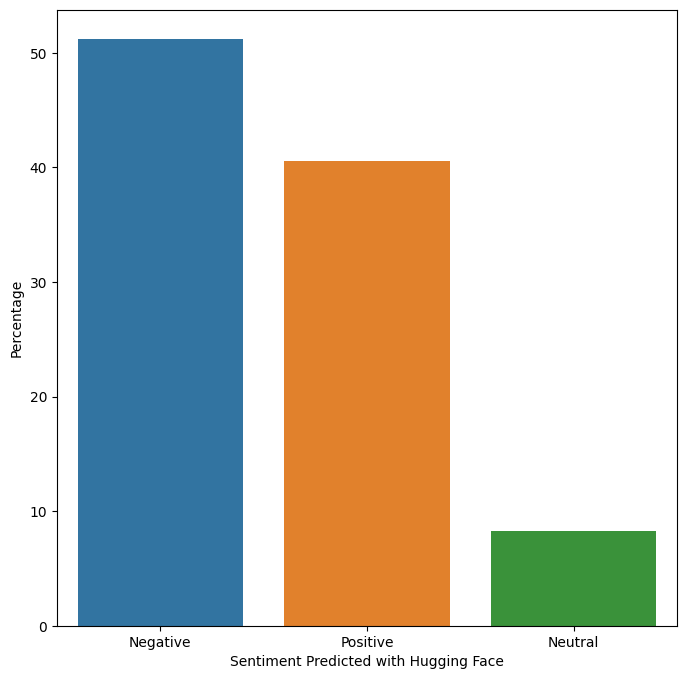

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = hf_prediction.hf_prediction.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Positive', 'Neutral'])
ax.set_ylabel("Percentage")
ax.set_xlabel("Sentiment Predicted with Hugging Face")

plt.show()

In [ ]:
#References
#https://github.com/asad70/reddit-sentiment-analysis/blob/master/reddit-sentiment-analysis.py
#https://github.com/Mellaw/BDC_Reddit/blob/main/Analyses_Main.ipynb